# Quantum Programming Exploration

In [1]:
import math
from qiskit import *
from qiskit.visualization import plot_bloch_multivector, plot_histogram
%matplotlib inline

qiskit.__qiskit_version__

{'qiskit-terra': '0.15.1',
 'qiskit-aer': '0.6.1',
 'qiskit-ignis': '0.4.0',
 'qiskit-ibmq-provider': '0.8.0',
 'qiskit-aqua': '0.7.5',
 'qiskit': '0.20.0'}

### Quantum
The smallest amount of energy that can be measured.

### Qubit

A quantum bit is a 2 state quantum device. For a computer, it means it can be 0 || 1 || 0 && 1.

### Qubit States

A qubit state is a superposition of basics states. It can be described by a linear combinaison:

$|\psi\rangle = \alpha|0\rangle + \beta|1\rangle$

Generally, $\alpha$ and $\beta$ are complex numbers. According to quantum mechanics, the probability to outcome:
- $|0\rangle$ ('0') is $|\alpha|^2$
- $|1\rangle$ ('1') is $|\beta|^2$

So we get, $|\alpha|^2 + |\beta|^2 = 1$

Example: <b>Schrödinger's cat</b>

We dont know if the cat in the box is dead or alive. We consider every possibilities.
So his states can be:

- Dead
- Alive
- $\frac{1}{\sqrt{2}}\cdot (|\text{Dead}\rangle + |\text{Alive}\rangle$)

### Superposition

It is where a qubit is, while left unobserved, all of its possible states.
When it will be observed it will collapse into one of possible states.

###  Entanglement

It is a phenomenon in which two particles (or groups of particles) form a linked system, and have quantum states that depend on each other regardless of the distance between them.

#### CNOT (cx() method)

It will flip the second qubit if the first one is 1.

In [2]:
# 3 qubits / 3 classical bits
C=QuantumCircuit(3,3)

         #           Result
C.h(0)   #   1,0,0 or 0,0,0 | Put this qubit in superposition
C.cx(0,1)#   1,1,0 or 0,0,0 | CNOT gate on qubit n°1
C.cx(0,2)#   1,1,1 or 0,0,0 | CNOT gate on qubit n°2

# Measure qubit 0,1,2 to classical bits 0,1,2
C.measure([0,1,2], [0,1,2])

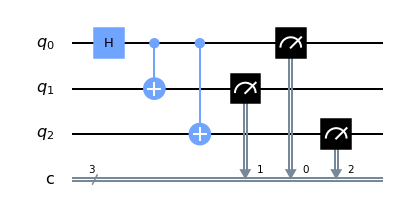

In [3]:
C.draw("mpl")

In [4]:
from qiskit import Aer

# Simulation
def run_qcircuit(c,  # Circuit
                 b,  # Backend
                 s,  # Shots
                 e): # N Executions
    
    backend=Aer.get_backend(b)
    probs=[execute(c,backend,shots=s).result().get_counts(c) for x in range(5)]
    legend=["Execution_"+str(x+1) for x in range(e)]
    return probs,legend

probs,legend=run_qcircuit(C,"qasm_simulator",1000,5)

In [5]:
[x.name() for x in Aer.backends()]

['qasm_simulator',
 'statevector_simulator',
 'unitary_simulator',
 'pulse_simulator']

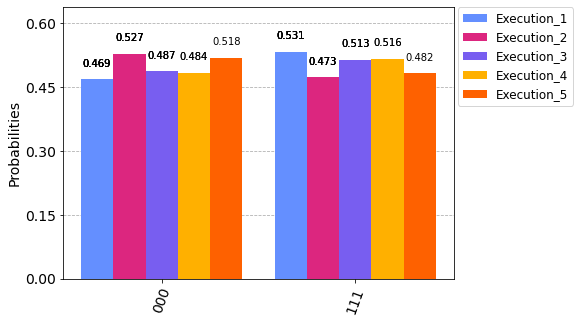

In [6]:
from qiskit.visualization import plot_histogram
plot_histogram(probs,legend=legend)

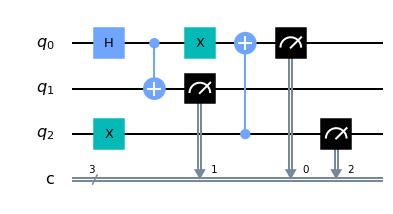

In [7]:
# Circuit
qc = QuantumCircuit(3, 3)
qc.h(0)
qc.cx(0, 1)
qc.x(0)
qc.x(2)
qc.cx(2, 0)
qc.measure([0, 1, 2], [0, 1 ,2])
qc.draw("mpl")

## Simulation with noise (on real quantum computer)

### Noise

Quantum noise refers to the uncertainty of a physical quantity due to its quantum origin.
The origin of noise can be explained with appearances and disappearances of quanta (plural of quantum element) spontaneously in space-time due to the laws of conservation. This could manifest itself as quantum decoherence in an entangled system.


### Quantum decoherence

With quantum phenomen due to environment influence, superposition become undetectable, but still there.

/usr/local/lib/python3.8/dist-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


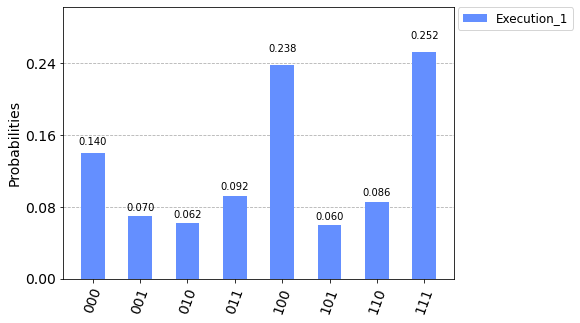

In [8]:
from qiskit import IBMQ
#IBMQ.save_account(open("token.txt","r").read())
IBMQ.load_account()
provider=IBMQ.get_provider("ibm-q")
backend=provider.get_backend("ibmq_burlington")
probs=execute(qc,backend=backend,shots=500).result().get_counts(qc)
plot_histogram(probs, legend=["Execution_1"])

## Simulation with noise (building my own noise model)

In [9]:
# Noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error

In [10]:
# Empty model
noise_model = NoiseModel()
noise_model

NoiseModel: Ideal

In [11]:
# Qubit flip error

# Error probabilities
p_gate=0.09
p_measure=0.12

# Errors
error_gate=pauli_error([('X',p_gate), ('I', 1 - p_gate)])
error_measure=pauli_error([('X',p_measure), ('I', 1 - p_measure)])

# Add to noise_model
noise_model.add_all_qubit_quantum_error(error_measure,"measure")
noise_model

NoiseModel:
  Basis gates: ['cx', 'id', 'u3']
  Instructions with noise: ['measure']
  All-qubits errors: ['measure']

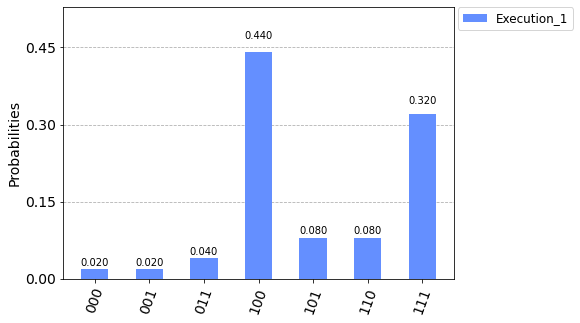

In [12]:
# simulator = QasmSimulator()

backend=Aer.get_backend("qasm_simulator")
probs=execute(qc,
              backend=backend,
              basis_gates=noise_model.basis_gates,
              shots=50,
             noise_model=noise_model).result().get_counts(0)
plot_histogram(probs, legend=["Execution_1"])

## Simulation without noise (Ideal)

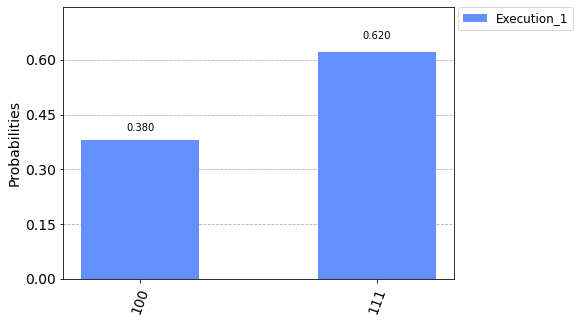

In [13]:
backend=Aer.get_backend("qasm_simulator")
probs=execute(qc,backend=backend,shots=50).result().get_counts(qc)
plot_histogram(probs, legend=["Execution_1"])

## Advanced circuit (composite gate)

#### barrier() method 
Used to avoid some operations with the <b>transpiler</b> (compile(circuit,backend)), for example, it can be used to avoid combination of gates.

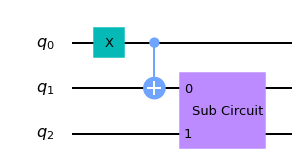

In [14]:
# Sub circuit
SUB_QR=QuantumRegister(2)
SUB_C=QuantumCircuit(SUB_QR,name="Sub Circuit") # Sub Circuit 1
#SUB_C.barrier()
SUB_C.h([SUB_QR[0],SUB_QR[1]])
SUB_C.x(SUB_QR[0])

# Convert gate + put it somewhere
# Circuits are not further decomposed during conversion to allow 
# the design of circuits at higher levels of abstraction.
SUB_INST=SUB_C.to_instruction()

# Main circuit
QR=QuantumRegister(3,'q')
C=QuantumCircuit(QR)
C.x(QR[0])
C.cx(QR[0],QR[1])
C.append(SUB_INST,[QR[1],QR[2]])

C.draw("mpl")

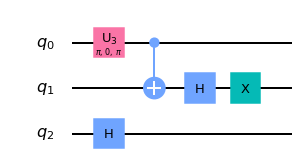

In [15]:
C.decompose().draw("mpl")